# Make Heatmap Plots of Sensitivity Analysis Results

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd

In [2]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = "Times New Roman"
plt.rcParams['mathtext.it'] = "Times New Roman:italic"
plt.rcParams['mathtext.bf'] = "Times New Roman:bold"

In [3]:
plot_dir = 'plots'
results_dir = 'results/sens'

In [4]:
os.listdir(results_dir)

['rod_obs_sim_2_6.csv',
 '.DS_Store',
 'rod_obs_sim_1_6.csv',
 'rod_obs_sim_sens_1_summary.csv',
 'rod_obs_sim_sens_2_summary.csv']

## Function to plot heatmap

In [5]:
def make_sensitivity_heatmap(data, centre_point, xlabel, ylabel, ax=None, 
                             title=None, minmax=None, transform=None, cmap='coolwarm', 
                             reverse_y=True, fmt='{:.2f}'):
    """Make a custom heatmap plot to show the sensitivity results
    data.
    """

    # See documentation example:
    # https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

    # Transform data
    if callable(transform):
        plot_data = transform(data)
    elif transform is None:
        plot_data = data
    elif transform == 'diff':
        centre_value = data.loc[centre_point]
        plot_data = data - centre_value
    elif transform == 'fraction':
        centre_value = data.loc[centre_point]
        plot_data = (data - centre_value) / centre_value
    elif transform == 'pct':
        centre_value = data.loc[centre_point]
        plot_data = 100 * (data - centre_value) / centre_value
    else:
        raise ValueError("invalid plot type")
    
    if minmax is None:
        minmax = (np.min(plot_data.values), np.max(plot_data.values))

    if reverse_y:
        plot_data = plot_data.iloc[::-1, :]

    pct_diff_idx = np.round(100 * (plot_data.index - centre_point[0]) 
                    / centre_point[0]).astype('int')
    pct_diff_cols = np.round(100 * (plot_data.columns - centre_point[1]) 
                     / centre_point[1]).astype('int')

    if ax is None:
        ax = plt.gca()

    im = ax.imshow(plot_data, aspect='auto', vmin=minmax[0], vmax=minmax[1], 
                   cmap=cmap)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(plot_data.columns)), labels=pct_diff_cols)
    ax.set_yticks(np.arange(len(plot_data.index)), labels=pct_diff_idx)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title)

    # Loop over data dimensions and create text annotations.
    for i, idx in enumerate(plot_data.index):
        for j, col in enumerate(plot_data.columns):
            text = ax.text(j, i, fmt.format(plot_data.loc[idx, col]), 
                           ha="center", va="center")
    #fig.colorbar()

## Sensitivity to process model parameters

Note: Because the model was initially specified as a continuous time model with parameters Kp Tp1 and d, and then converted to discrete time, the parameters are not included in the results file.

In [6]:
filename= 'rod_obs_sim_sens_1_summary.csv'

summary_results = pd.read_csv(os.path.join(results_dir, filename))
summary_results.shape

(49, 1220)

In [7]:
var_names = ['Kp', 'Tp1']  # static gain and time constant
centre_points = {'Kp': -32.4, 'Tp1': 0.106}

# Re-create variable values if not included in summary_results
var_ratios = np.array([1/2, 1/1.5, 1/1.15, 1, 1.15, 1.5, 2])
n = len(var_ratios)
combs = [(i+1, j+1) for j in range(n) for i in range(n)]
combs = np.array([(i, j) for j in range(n) for i in range(n)])
var_values = pd.DataFrame(var_ratios[combs] * np.array(list(centre_points.values())),
                          columns=var_names, index=summary_results.index)
if var_names[0] not in summary_results:
    summary_results = pd.concat([var_values, summary_results], axis=1)
var_values.head()

,Kp,Tp1
0,-16.200000,0.053
1,-21.600000,0.053
2,-28.173913,0.053
3,-32.400000,0.053
4,-37.260000,0.053


In [8]:
var_values = {name: summary_results[name].unique().tolist() for name in var_names}
for name in var_names:
    x = pd.Series(var_values[name], name=name)
    pct_chg = pd.Series((100*(x - centre_points[name]) / centre_points[name]).round(0).astype(int), name='%')
    values = pd.concat([x, pct_chg], axis=1)
    print(values)

          Kp    %
0 -16.200000  -50
1 -21.600000  -33
2 -28.173913  -13
3 -32.400000    0
4 -37.260000   15
5 -48.600000   50
6 -64.800000  100
        Tp1    %
0  0.053000  -50
1  0.070667  -33
2  0.092174  -13
3  0.106000    0
4  0.121900   15
5  0.159000   50
6  0.212000  100


In [9]:
summary_results.head()

,Time,Kp,Tp1,p_case,i_in_seq,t_stop,Ts,nT,nu,ny,...,RMSE_y_est_MKF_SP,RMSE_tr_y_est_MKF_SP,RMSE_ss_y_est_MKF_SP,Var_ss_y_est_MKF_SP,RMSD_ss_y_est_MKF_SP,RMSE_y_est_SKF,RMSE_tr_y_est_SKF,RMSE_ss_y_est_SKF,Var_ss_y_est_SKF,RMSD_ss_y_est_SKF
0,09-Dec-2022 13:51:19,-16.200000,0.053,1,6,123,0.05,2460,0,1,...,1.698317,2.637647,1.221416,0.713506,0.415816,1.452646,2.032801,1.191166,0.574288,0.315723
1,09-Dec-2022 13:51:47,-21.600000,0.053,1,6,123,0.05,2460,0,1,...,1.755426,2.570421,1.369752,1.026076,0.524356,1.468984,1.966286,1.254538,0.747852,0.401437
2,09-Dec-2022 13:52:13,-28.173913,0.053,1,6,123,0.05,2460,0,1,...,1.775841,2.486278,1.455481,1.274374,0.629678,1.535754,1.979379,1.351080,0.994444,0.500956
3,09-Dec-2022 13:52:39,-32.400000,0.053,1,6,123,0.05,2460,0,1,...,1.790326,2.433185,1.508985,1.434606,0.693267,1.586353,2.006010,1.414609,1.162543,0.562493
4,09-Dec-2022 13:53:05,-37.260000,0.053,1,6,123,0.05,2460,0,1,...,1.817170,2.387725,1.575407,1.630616,0.765269,1.645663,2.042188,1.486027,1.360096,0.631189


In [10]:
centre_point = (-32.4, 0.106)
xlabel = "% change in time constant ($T_{p1}$)"
ylabel = "% change in static gain ($K_p$)"
minmax = (-0.5, 0.5)

In [11]:
A_matrix_labels = [f'sys_A_{i+1}_{j+1}' for j in range(4) for i in range(4)]
C_matrix_labels = [f'sys_C_{j+1}' for j in range(4)]
sys_matrices = np.unique(summary_results[A_matrix_labels + C_matrix_labels].to_numpy(), axis=0)
print(sys_matrices.shape)
assert(sys_matrices.shape[0] == summary_results.shape[0])

(49, 20)


In [12]:
n_obs = summary_results.loc[:, 'n_obs'].iloc[0]
assert((n_obs == summary_results.loc[:, 'n_obs']).all())
labels = [f'obs_{i}' for i in range(1, n_obs+1)]
obs_labels = summary_results.loc[:, labels].iloc[0].tolist()
obs_labels

['KF1', 'KF3', 'MKF_SF95', 'MKF_SF1', 'MKF_SP', 'SKF']

In [13]:
metric_labels = ['RMSE_y_est', 'RMSE_tr_y_est', 'RMSE_ss_y_est', 
           'Var_ss_y_est', 'RMSD_ss_y_est']
obs_label = 'KF3'
labels = [f'{metric_label}_{obs_label}' for metric_label in metric_labels]
data = summary_results.set_index(var_names)[labels]
data.shape

(49, 5)

In [14]:
sensitivity_data = data.unstack(level=-1)
sensitivity_data.shape

(7, 35)

In [15]:
sensitivity_data[f'RMSE_y_est_{obs_label}']

Tp1,0.053000,0.070667,0.092174,0.106000,0.121900,0.159000,0.212000
Kp,,,,,,,
-64.800000,2.272165,2.245724,2.212479,2.192707,2.187255,2.144137,2.083999
-48.600000,2.070264,2.052176,2.031363,2.018772,2.018304,1.991232,1.980721
-37.260000,1.921464,1.911796,1.900278,1.904795,1.895423,1.881206,1.881087
-32.400000,1.863354,1.857103,1.849516,1.853803,1.847515,1.838987,1.842417
-28.173913,1.821525,1.818007,1.819133,1.816985,1.813425,1.809728,1.815233
-21.600000,1.792387,1.792039,1.791846,1.791925,1.792493,1.794691,1.800742
-16.200000,1.840566,1.836376,1.837207,1.838140,1.818013,1.821112,1.847719


## Make all heatmaps for selected observer

In [16]:
centre_point

(-32.4, 0.106)

RMSE_y_est
Saved to: rod_obs_sim_sens_rod_KF3_RMSE_y_est.png


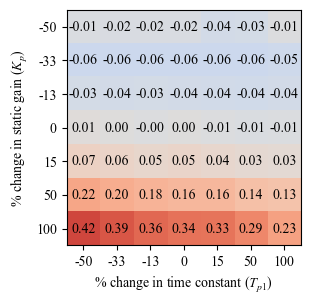

RMSE_tr_y_est
Saved to: rod_obs_sim_sens_rod_KF3_RMSE_tr_y_est.png


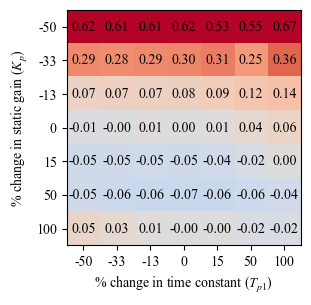

RMSE_ss_y_est
Saved to: rod_obs_sim_sens_rod_KF3_RMSE_ss_y_est.png


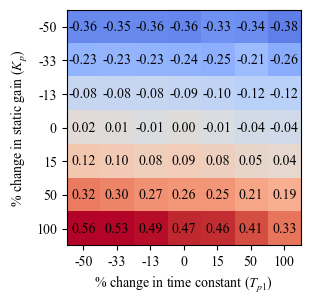

Var_ss_y_est
Saved to: rod_obs_sim_sens_rod_KF3_Var_ss_y_est.png


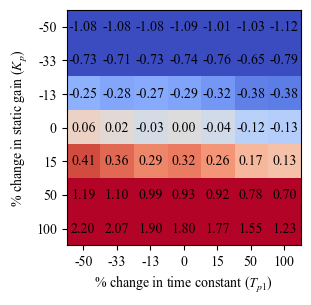

RMSD_ss_y_est
Saved to: rod_obs_sim_sens_rod_KF3_RMSD_ss_y_est.png


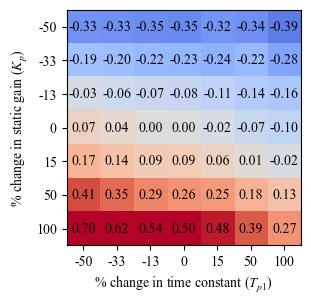

In [17]:
for metric_label in metric_labels:
    data = sensitivity_data[f'{metric_label}_{obs_label}']
    print(metric_label)
    plt.figure(figsize=(3.21, 3.15))
    make_sensitivity_heatmap(data, centre_point, xlabel, ylabel,
                             transform='diff', minmax=[-0.5, 0.5], fmt='{:.2f}')
    plt.tight_layout()
    filename = f'rod_obs_sim_sens_rod_{obs_label}_{metric_label}.pdf'
    plt.savefig(os.path.join(plot_dir, filename))
    filename = f'rod_obs_sim_sens_rod_{obs_label}_{metric_label}.png'
    plt.savefig(os.path.join(plot_dir, filename), dpi=300)
    print(f"Saved to: {filename}")
    plt.show()

## Make heatmaps for selected observers

In [18]:
n_obs = summary_results.loc[:, 'n_obs'].iloc[0]
assert((n_obs == summary_results.loc[:, 'n_obs']).all())
labels = [f'obs_{i}' for i in range(1, n_obs+1)]
obs_labels = summary_results.loc[:, labels].iloc[0].tolist()
obs_labels

['KF1', 'KF3', 'MKF_SF95', 'MKF_SF1', 'MKF_SP', 'SKF']

In [19]:
obs_labels_select = ['MKF_SF95', 'MKF_SF1', 'MKF_SP', 'KF3']
# ['RMSE_y_est', 'RMSE_tr_y_est', 'RMSE_ss_y_est', 'Var_ss_y_est', 'RMSD_ss_y_est']
metric_label = 'RMSE_y_est'

labels = [f'{metric_label}_{obs_label}' for obs_label in obs_labels_select]
data = summary_results.set_index(var_names)[labels]
data.shape

(49, 4)

In [20]:
sensitivity_data = data.unstack(level=-1)
sensitivity_data.shape

(7, 28)

RMSE_y_est
Saved to: rod_obs_sim_sens_sys_3obs_RMSE_y_est.pdf


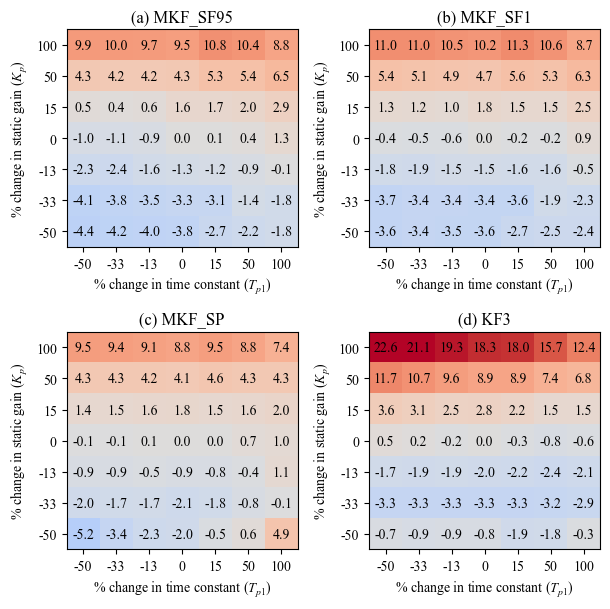

In [21]:
print(metric_label)
fig, axes = plt.subplots(2, 2, figsize=(6.2, 6.2))

if len(obs_labels_select) < 4:
    axes[1, 1].remove()

c = 'a'
for obs_label, ax in zip(obs_labels_select, axes.flatten()):
    data = sensitivity_data[f'{metric_label}_{obs_label}']    
    make_sensitivity_heatmap(
        data, centre_point, xlabel, ylabel, ax=ax, 
        title=f"({c}) {obs_label}",
        transform='pct', minmax=[-20, 20], fmt='{:.1f}',
        reverse_y=False
    )
    # Increment index letter
    c = chr(ord(c) + 1)

plt.tight_layout()
filename = f'rod_obs_sim_sens_sys_3obs_{metric_label}.pdf'
plt.savefig(os.path.join(plot_dir, filename))
print(f"Saved to: {filename}")
filename = f'rod_obs_sim_sens_sys_3obs_{metric_label}.png'
plt.savefig(os.path.join(plot_dir, filename), dpi=300)
plt.show()

## Sensitivity to RODD parameters

In [22]:
filename= 'rod_obs_sim_sens_2_summary.csv'

summary_results = pd.read_csv(os.path.join(results_dir, filename))
summary_results.shape

(49, 1218)

In [23]:
summary_results.head()

,Time,p_case,i_in_seq,t_stop,Ts,nT,nu,ny,n_obs,sys_A_1_1,...,RMSE_y_est_MKF_SP,RMSE_tr_y_est_MKF_SP,RMSE_ss_y_est_MKF_SP,Var_ss_y_est_MKF_SP,RMSD_ss_y_est_MKF_SP,RMSE_y_est_SKF,RMSE_tr_y_est_SKF,RMSE_ss_y_est_SKF,Var_ss_y_est_SKF,RMSD_ss_y_est_SKF
0,09-Dec-2022 12:14:03,2,6,123,0.05,2460,0,1,6,2.247884,...,1.796496,2.529329,1.464108,1.283650,0.575713,1.598362,1.973873,1.447813,1.25207,0.56131
1,09-Dec-2022 12:14:27,2,6,123,0.05,2460,0,1,6,2.247884,...,1.792134,2.506335,1.470440,1.302623,0.583979,1.598362,1.973873,1.447813,1.25207,0.56131
2,09-Dec-2022 12:14:51,2,6,123,0.05,2460,0,1,6,2.247884,...,1.793523,2.492310,1.480826,1.326491,0.593311,1.598362,1.973873,1.447813,1.25207,0.56131
3,09-Dec-2022 12:15:14,2,6,123,0.05,2460,0,1,6,2.247884,...,1.791378,2.478544,1.485235,1.339982,0.598975,1.598362,1.973873,1.447813,1.25207,0.56131
4,09-Dec-2022 12:15:36,2,6,123,0.05,2460,0,1,6,2.247884,...,1.788612,2.462797,1.489711,1.354635,0.605146,1.598362,1.973873,1.447813,1.25207,0.56131


In [24]:
obs_label = 'MKF_SF95'
centre_point = (0.01, 0.2717)
xlabel = "% change in $\sigma_{w_p}$"
ylabel = "% change in $\epsilon$"
minmax = (-0.5, 0.5)

In [25]:
n_obs = summary_results.loc[:, 'n_obs'].iloc[0]
assert((n_obs == summary_results.loc[:, 'n_obs']).all())
labels = [f'obs_{i}' for i in range(1, n_obs+1)]
obs_labels = summary_results.loc[:, labels].iloc[0].tolist()
obs_labels

['KF1', 'KF3', 'MKF_SF95', 'MKF_SF1', 'MKF_SP', 'SKF']

In [26]:
var_names = ['epsilon', 'sigma_wp_1_2']
centre_points = {'epsilon': 0.01, 'sigma_wp_1_2': 0.2717}
var_values = {name: summary_results[name].unique().tolist() for name in var_names}
for name in var_names:
    x = pd.Series(var_values[name], name=name)
    pct_chg = pd.Series((100*(x - centre_points[name]) / centre_points[name]).round(0).astype(int), name='%')
    values = pd.concat([x, pct_chg], axis=1)
    print(values)

    epsilon    %
0  0.005000  -50
1  0.006667  -33
2  0.008696  -13
3  0.010000    0
4  0.011500   15
5  0.015000   50
6  0.020000  100
   sigma_wp_1_2    %
0      0.135850  -50
1      0.181133  -33
2      0.236261  -13
3      0.271700    0
4      0.312455   15
5      0.407550   50
6      0.543400  100


In [27]:
metric_labels = ['RMSE_y_est', 'RMSE_tr_y_est', 'RMSE_ss_y_est', 
           'Var_ss_y_est', 'RMSD_ss_y_est']
labels = [f'{metric_label}_{obs_label}' for metric_label in metric_labels]
data = summary_results.set_index(var_names)[labels]
data.shape

(49, 5)

In [28]:
sensitivity_data = data.unstack(level=-1)
sensitivity_data.shape

(7, 35)

In [29]:
sensitivity_data[f'RMSE_y_est_{obs_label}']

sigma_wp_1_2,0.135850,0.181133,0.236261,0.271700,0.312455,0.407550,0.543400
epsilon,,,,,,,
0.005000,1.783358,1.779017,1.779609,1.781390,1.783808,1.789386,1.796222
0.006667,1.779191,1.775762,1.777981,1.780689,1.784008,1.791158,1.799413
0.008696,1.776093,1.774337,1.778744,1.782627,1.787071,1.796167,1.806098
0.010000,1.774930,1.774424,1.780286,1.784932,1.790102,1.800444,1.811416
0.011500,1.774199,1.775225,1.782779,1.788301,1.794305,1.806061,1.818196
0.015000,1.774326,1.779127,1.790631,1.798175,1.806095,1.821076,1.835799
0.020000,1.777338,1.787649,1.804683,1.815040,1.825616,1.845015,1.863220


In [30]:
metric_labels

['RMSE_y_est',
 'RMSE_tr_y_est',
 'RMSE_ss_y_est',
 'Var_ss_y_est',
 'RMSD_ss_y_est']

## Make all heatmaps for selected observer

RMSE_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF95_RMSE_y_est.png


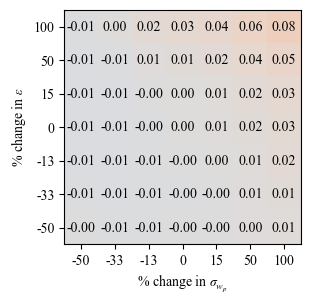

RMSE_tr_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF95_RMSE_tr_y_est.png


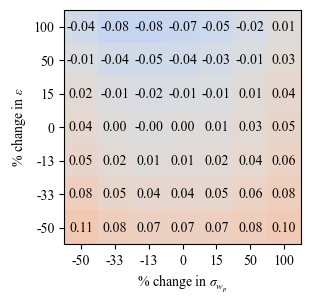

RMSE_ss_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF95_RMSE_ss_y_est.png


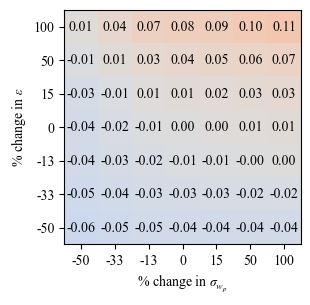

Var_ss_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF95_Var_ss_y_est.png


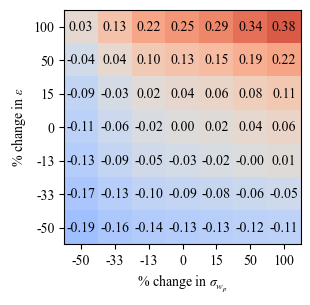

RMSD_ss_y_est
Saved to: rod_obs_sim_sens_rod_MKF_SF95_RMSD_ss_y_est.png


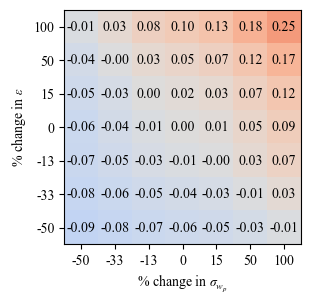

In [31]:
for metric_label in metric_labels:
    data = sensitivity_data[f'{metric_label}_{obs_label}']
    print(metric_label)
    plt.figure(figsize=(3.21, 3.15))
    make_sensitivity_heatmap(data, centre_point, xlabel, ylabel,
                             transform='diff', minmax=[-0.5, 0.5], fmt='{:.2f}')
    plt.tight_layout()
    filename = f'rod_obs_sim_sens_rod_{obs_label}_{metric_label}.pdf'
    plt.savefig(os.path.join(plot_dir, filename))
    filename = f'rod_obs_sim_sens_rod_{obs_label}_{metric_label}.png'
    plt.savefig(os.path.join(plot_dir, filename), dpi=300)
    print(f"Saved to: {filename}")
    plt.show()

## Make heatmaps for selected observers

In [32]:
n_obs = summary_results.loc[:, 'n_obs'].iloc[0]
assert((n_obs == summary_results.loc[:, 'n_obs']).all())
labels = [f'obs_{i}' for i in range(1, n_obs+1)]
obs_labels = summary_results.loc[:, labels].iloc[0].tolist()
obs_labels

['KF1', 'KF3', 'MKF_SF95', 'MKF_SF1', 'MKF_SP', 'SKF']

In [33]:
obs_labels_select = ['MKF_SF95', 'MKF_SF1', 'MKF_SP']  # TODO: need to check sims for SKF
# ['RMSE_y_est', 'RMSE_tr_y_est', 'RMSE_ss_y_est', 'Var_ss_y_est', 'RMSD_ss_y_est']
metric_label = 'RMSE_y_est'

labels = [f'{metric_label}_{obs_label}' for obs_label in obs_labels_select]
data = summary_results.set_index(var_names)[labels]
data.shape

(49, 3)

In [34]:
sensitivity_data = data.unstack(level=-1)
sensitivity_data.shape

(7, 21)

RMSE_y_est
Saved to: rod_obs_sim_sens_rod_3obs_RMSE_y_est.pdf


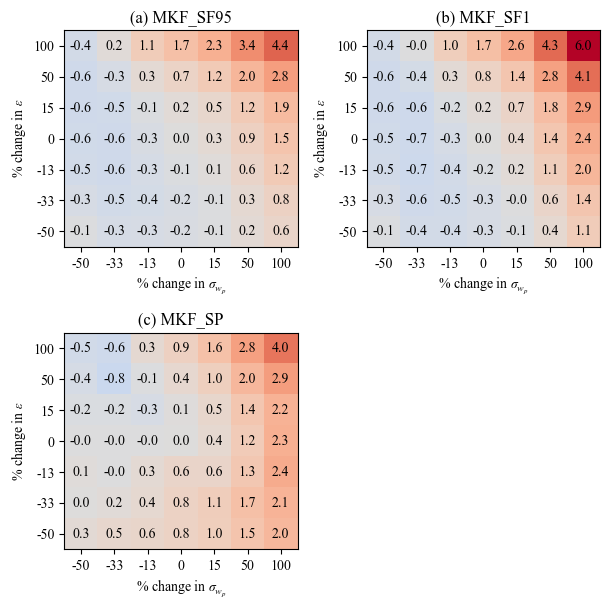

In [35]:
print(metric_label)
fig, axes = plt.subplots(2, 2, figsize=(6.2, 6.2))

if len(obs_labels_select) == 3:
    axes[1, 1].remove()

c = 'a'
for obs_label, ax in zip(obs_labels_select, axes.flatten()):
    data = sensitivity_data[f'{metric_label}_{obs_label}']
    make_sensitivity_heatmap(
        data, centre_point, xlabel, ylabel, ax=ax, 
        title=f"({c}) {obs_label}",
        transform='pct', minmax=[-6, 6], fmt='{:.1f}',
        reverse_y=True
    )
    # Increment index letter
    c = chr(ord(c) + 1)

plt.tight_layout()
filename = f'rod_obs_sim_sens_rod_3obs_{metric_label}.pdf'
plt.savefig(os.path.join(plot_dir, filename))
print(f"Saved to: {filename}")
filename = f'rod_obs_sim_sens_rod_3obs_{metric_label}.png'
plt.savefig(os.path.join(plot_dir, filename), dpi=300)
plt.show()